# import pkg & get GPU


In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers


import time
!pip install -q imageio
from IPython import display
tf.enable_eager_execution()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Num GPUs Available:  1


True

# load data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip drive/My\ Drive/AFAD.zip

In [0]:
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dir_data      = "/content/AFAD"
Ntrain        = 165000 
Ntest         = 100
nm_imgs       = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]
img_shape     = (64, 64, 3)

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
      
        image = load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)/255.0
        X_train.append(image)
        if i % 10000 == 0:
          print(i)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test)
print("X_test.shape = {}".format(X_test.shape))

Using TensorFlow backend.


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
X_train.shape = (165000, 64, 64, 3)
0
X_test.shape = (100, 64, 64, 3)


In [0]:
# X_train= X_train.reshape(X_train.shape[0], 64, 64, 3).astype('float32')
BUFFER_SIZE = 165000
BATCH_SIZE = 128
# X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder = True)


# Generator


In [0]:
def make_generator_model():
  
  model =tf.keras.models.Sequential()
  model.add(layers.InputLayer((100,)))
  model.add( layers.Dense( 2048, use_bias=False,  input_shape=(100,) )  )
  model.add( layers.Dense( 8*8*128, use_bias=False, activation="relu"  ) )
  model.add( layers.BatchNormalization( momentum=0.55 ) )
  model.add( layers.Reshape((8,8,128)))
  model.add(layers.Dropout(0.2))


  model.add( layers.Conv2DTranspose(256, (2,2), strides=(2, 2), padding='same',use_bias=False ) )#16
  model.add( layers.BatchNormalization( momentum=0.55) )
  model.add( layers.LeakyReLU(0.2) )

  model.add( layers.Conv2DTranspose(128, (2,2), strides=(2, 2), padding='same', use_bias=False ) )#32
  model.add( layers.BatchNormalization( momentum=0.55 ) )
  model.add(layers.Dropout(0.2))

  model.add( layers.Conv2DTranspose(64, (2,2), strides=(1, 1), padding='same', use_bias=False ) )#32
  model.add( layers.BatchNormalization( momentum=0.55 ) )
  model.add(layers.Dropout(0.2))

  model.add( layers.Conv2DTranspose(64, (2,2), strides=(2, 2), padding='same', use_bias=False ) )# 64
  model.add( layers.BatchNormalization( momentum=0.51 ) )
  model.add(layers.Dropout(0.3))


  model.add( layers.Conv2DTranspose(3, (2,2), strides=(1, 1), padding='same', use_bias=False,  activation='sigmoid') )


  return model

# Test generator

In [3]:

generator = make_generator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.00007,0.5),
generator.compile(loss='binary_crossentropy', optimizer =tf.keras.optimizers.Adam(0.00007,0.5))
generator.summary()
# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)
# print(generated_image.numpy())

# plt.imshow(generated_image[0, :, :, :].numpy())
# print(generated_image[0, :, :, :].numpy().shape)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              204800    
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              16777216  
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1

 x# New Section

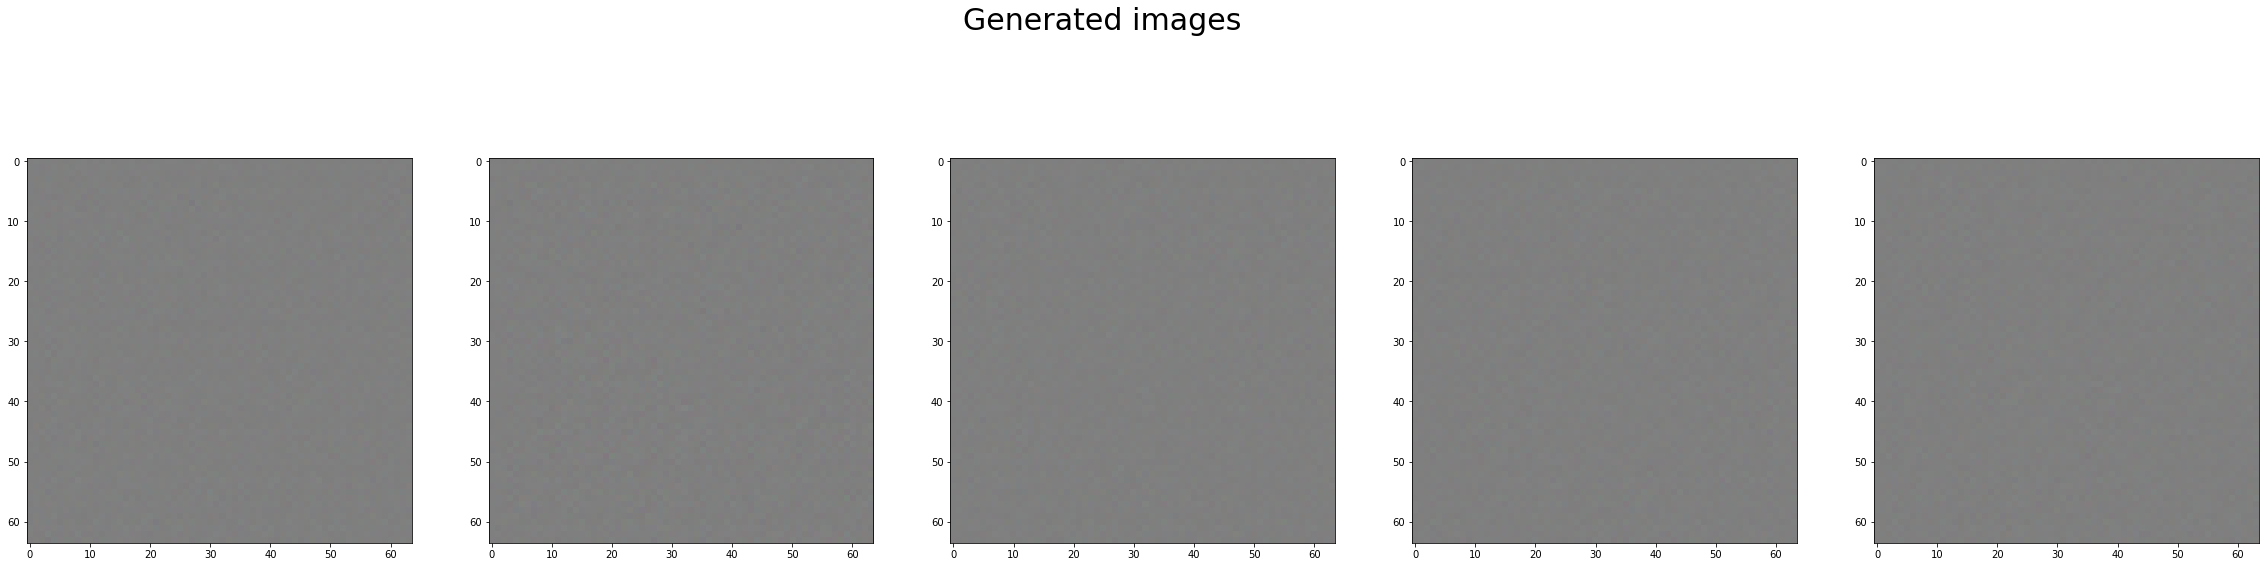

In [0]:
def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,5,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()
noise = np.random.normal(0,1,(5,100))
# print(noise[0],'wwww',noise[1])
plot_generated_images(noise)


In [0]:
def make_discriminator_model():
  
  model = tf.keras.Sequential()


  model.add( layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape= [64,64,3]  ) )
  model.add( layers.MaxPooling2D((2, 2), strides=(2,2)) )
  # model.add( layers.LeakyReLU(alpha=0.28) )  
  model.add(layers.Dropout(0.3))

  model.add( layers.Conv2D( 64, (3,3),  activation='relu', padding='same'  ) )
  model.add( layers.Conv2D( 64, (3,3),  activation='relu', padding='same' ) )
  # model.add( layers.MaxPooling2D((2, 2), strides=(2,2) ))


  model.add( layers.Conv2D( 128, (3,3), activation='relu', padding='same'  ) )
  model.add( layers.Conv2D( 128, (3,3), activation='relu', padding='same' ) )
  model.add(layers.Dropout(0.3))

  model.add( layers.Conv2D( 256, (3,3), activation='relu', padding='same'  ) )
  model.add( layers.Conv2D( 256, (3,3), activation='relu', padding='same' ) )

  model.add( layers.MaxPooling2D((2, 2), strides=(1,1)) )
  model.add(layers.Flatten())
  model.add(layers.Dense(1,activation='sigmoid'))


  # model.add( layers.LeakyReLU(alpha=0.28) )  
  # model.add(layers.Dropout(0.3))

  # model.add( layers.Conv2D( 256, (3,3), strides = (2,2), padding = 'same' ) )
  # model.add( layers.LeakyReLU(alpha=0.28) )  
  # model.add(layers.Dropout(0.3)) 

  # model.add( layers.Conv2D( 512, (3,3), strides = (2,2), padding = 'same' ) )
  # model.add( layers.LeakyReLU(alpha=0.28) )  
  # model.add(layers.Dropout(0.3))

  # model.add(layers.Flatten())
  # model.add(layers.Dense(1))

  return model



# Test Discriminater

In [5]:
discriminator = make_discriminator_model()
discriminator_optimizer = tf.keras.optimizers.Adam(0.00007,0.5)
discriminator.compile(loss= 'binary_crossentropy', optimizer = discriminator_optimizer,metrics   = ['accuracy'])
# img = generator(noise)
# predict = discriminator(img)
# print(predict)
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)      

# GAN

In [0]:
def build_gan(g,d):
    model = tf.keras.Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

# batch_size =128
# noise =  np.random.normal(0,1,(batch_size,100))
# valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)
# print(valid_y.shape)
# g_loss_batch = gan.train_on_batch(noise,valid_y)
# print('3333')

In [7]:
gan = build_gan(generator,discriminator)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4))
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 3)         17328896  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1409025   
Total params: 18,737,921
Trainable params: 17,311,488
Non-trainable params: 1,426,433
_________________________________________________________________


In [0]:

discriminator.save_weights('dtmp.h5')
generator.save_weights('gtmp.h5')

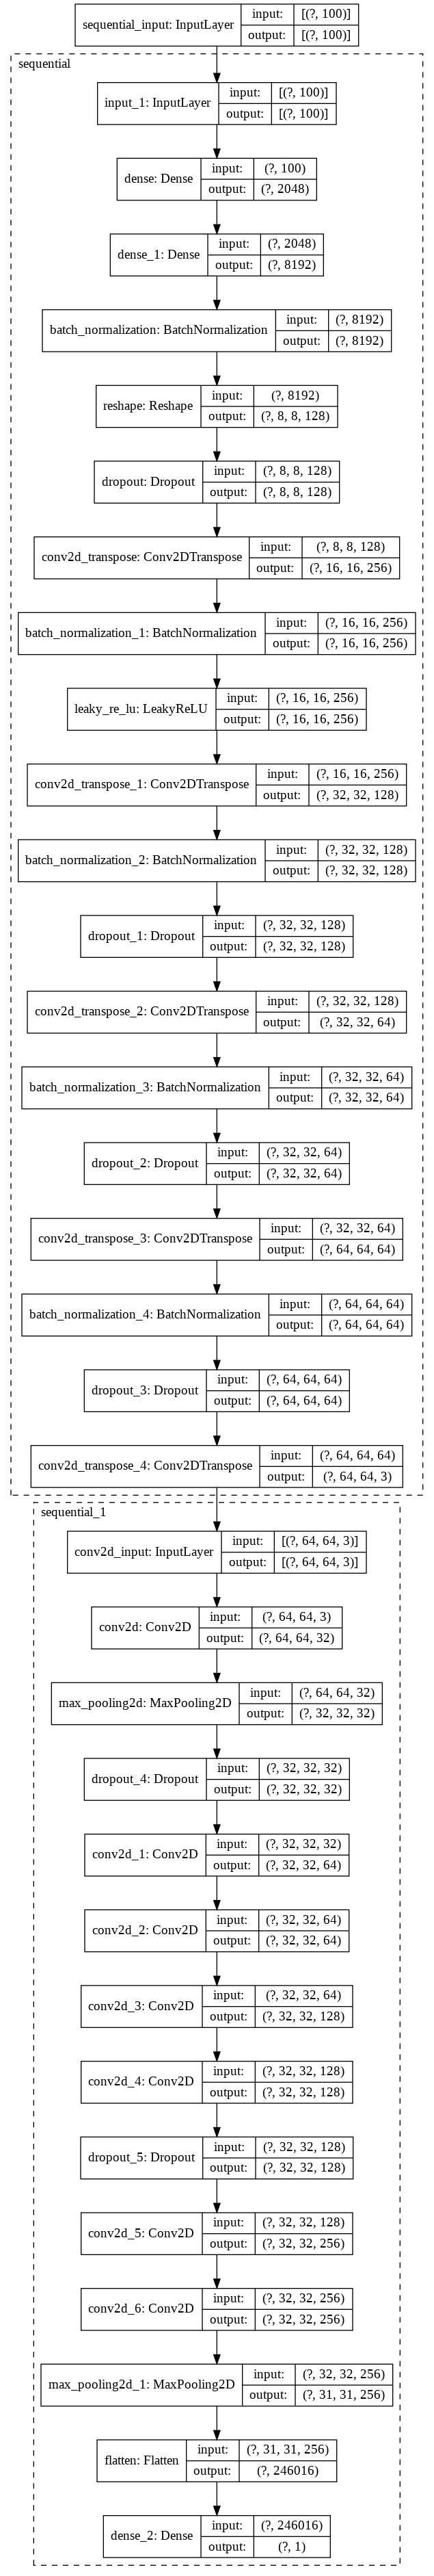

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(gan, to_file='gan.png',show_shapes=True,expand_nested=True)
# plot_model(generator, to_file='generator.png',show_shapes=True,expand_nested=True)



# Train 


In [0]:
def train(G, D,GAN,epochs,batch_size, start,des_dir ='/content/drive/My Drive/model_history1205'):
    generator = G
    discriminator = D
    gan = GAN
    history = list()
    for epoch in range(epochs):
        Dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder = True)
        batch_count = 0
        d_loss = (0,0)
        g_loss = (0,0)
        d_not_train = 0
        noise =  np.random.normal(0,1,(batch_size,100))
        for batch in Dataset:
            # D train
            # if d_not_train < 7:
            #   discriminator.trainable = True
            #   fake_images = generator.predict(noise)
            #   d_loss_real = discriminator.train_on_batch(batch, np.ones( (batch_size,1) ))
            #   d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size,1)))
            #   d_loss = 0.5*np.add(d_loss_real , d_loss_fake)
            #   ## check
            #   if d_loss[1] == 0.5 and batch_count != 0:
            #     generator.load_weights('gtmp.h5')
            #     # generator.load_weights('gtmp.h5')
            #   elif d_loss[1] < 0.95:
            #     discriminator.save_weights('dtmp.h5')
            #   elif d_loss[1] >= 0.95:
            #     discriminator.load_weights('dtmp.h5')
            #     d_not_train = d_not_train + 1
            # elif d_not_train == 7:
            #   d_not_train = 48
            # else:
            #   d_not_train = d_not_train - 8
            discriminator.trainable = True
            fake_images = generator.predict(noise)
            d_loss_real = discriminator.train_on_batch(batch, np.ones( (batch_size,1) ))
            d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size,1)))
            d_loss = 0.5*np.add(d_loss_real , d_loss_fake)
            # G train
            discriminator.trainable = False
            generator.trainable = True
            noise =  np.random.normal(0,1,(batch_size,100))
            valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)
            g_loss_batch = gan.train_on_batch(noise,valid_y)
            g_loss = np.add(g_loss , g_loss_batch)            
            discriminator.trainable = True

            # print result
            batch_count = batch_count + 1
            if (batch_count % 1000) == 0:
                fig = plt.figure(figsize=(30,10))
                img = generator.predict(noise)
                nplot = 4
                for count in range(1,nplot):
                    ax = fig.add_subplot(1,nplot,count)
                    ax.imshow(img[count])
                plt.savefig(str(epoch)+'_'+str(batch_count)+'.png')
                plt.show()
            # save model
            if (batch_count % 1000) == 0: 
                generator.save(des_dir+'/generator＿'+str(start+epoch)+'_'+str(batch_count)+'.h5',include_optimizer = True) 
                discriminator.save(des_dir+'/discriminator＿'+str(start +epoch)+'_'+str(batch_count)+'.h5',include_optimizer = True) 
                history.append(d_loss)
            if (batch_count % 50) == 0: 
                print('batch: {}, d_loss: {}'.format(batch_count, d_loss ), d_not_train)

            # Epoch end

        
        # d_loss = d_loss/batch_count
        # history.append((epoch,d_loss,g_loss))
        print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch,d_loss,g_loss))
        # generator.save(des_dir+'/generator＿'+str(start+epoch)+'.h5',include_optimizer = False) 
        # discriminator.save(des_dir+'/discriminator＿'+str(start +epoch)+'.h5',include_optimizer = False) 

    return history



In [0]:
history = train(generator, discriminator, gan, 50, BATCH_SIZE,0)

# Test result

In [0]:
# generator = tf.keras.models.load_model('/content/model_history/generator＿4.h5')
# discriminator = tf.keras.models.load_model('/content/model_history/discriminator＿4.h5')
plot_generated_images(noise)


# LOAD MODEL

In [0]:
# generator = tf.keras.models.load_model('/content/model_history/generator＿5_100.h5')
# discriminator = tf.keras.models.load_model('/content/model_history/discriminator＿5_100.h5')


# TESTTTTTTTTTTTTT

In [0]:
# !rm -r /content/model_history/

rm: cannot remove '/content/model_history/': No such file or directory


In [0]:
noise =  np.random.normal(0,1,(5,100))
plot_generated_images(noise)